# **Import packages**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score
import missingno as msno

### 직접 생성한 패키지
from My_code.Odor_Analysis import Odor
from My_code.Metrics import R2, MAPE, mae
from My_code.Useful import color_at_df, multi_table

# **데이터 불러오기 및 결측치 확인**

In [2]:
# data_path = "/Linux/Odor/DAT/"
# output_path = "/Linux/Odor/OUT/"

In [5]:
### 원 데이터
odor = pd.read_csv("../DAT/New_data2.csv", encoding="euc-kr")
odor = odor.drop(["yy", "mm", "dd", "farm"], axis = 1)    # 불필요한 변수 제거
odor.rename(columns = {"mm.1" : "mm"}, inplace = True)    # 추후 변수명을 편하게 사용하기 위해
print(odor.shape)
display(odor.head())

(57, 16)


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,NaN,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,NaN,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92
3,2080,1.02,344.0,NaN,13.0,0.63,490.79,570.61,51.09,719.27,168.48,237.64,8.90,60.56,5.55,7.31
4,310,1.18,312.0,NaN,NaN,NaN,404.53,468.03,43.17,573.75,157.22,205.67,9.21,69.90,NaN,5.43


In [6]:
### 결측값 확인
num_na = odor.isna().sum().sum()


print("NA 개수 :", num_na) #, " ND 개수 :",  num_nd)
na = pd.DataFrame(odor.isna().sum(), columns = ["NA"]).transpose()
na_per = np.round(na/odor.shape[0], 3)
na_per.index = ["NA (%)"]

na_df = pd.concat([na, na_per], axis = 0)
na_df

NA 개수 : 155


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
NA,0.0,0.0,0.0,31.000,36.000,52.000,0.0,1.000,1.000,1.000,0.0,1.000,2.000,1.000,21.000,8.00
NA (%),0.0,0.0,0.0,0.544,0.632,0.912,0.0,0.018,0.018,0.018,0.0,0.018,0.035,0.018,0.368,0.14


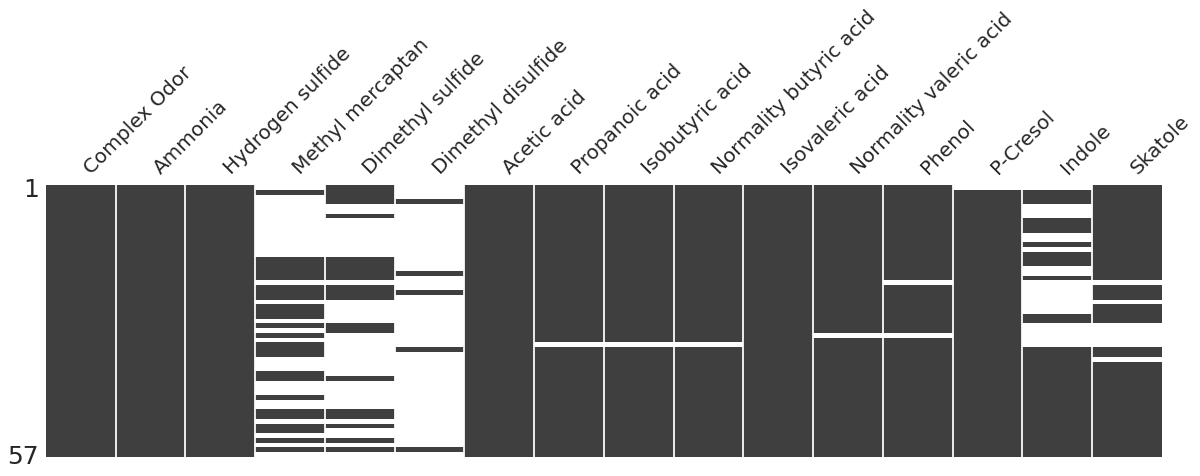

In [7]:
nan_odor = odor.copy()
nan_odor.columns = ["Complex Odor", "Ammonia", "Hydrogen sulfide", "Methyl mercaptan", "Dimethyl sulfide", "Dimethyl disulfide", "Acetic acid", "Propanoic acid", 
                    "Isobutyric acid", "Normality butyric acid", "Isovaleric acid", "Normality valeric acid", "Phenol", "P-Cresol", "Indole", "Skatole"]

msno.matrix(nan_odor, figsize=(20,5), fontsize = 20, sparkline = False)
# plt.title("Missing Value Matrix", fontsize = 15, fontweight = "bold")
plt.show()

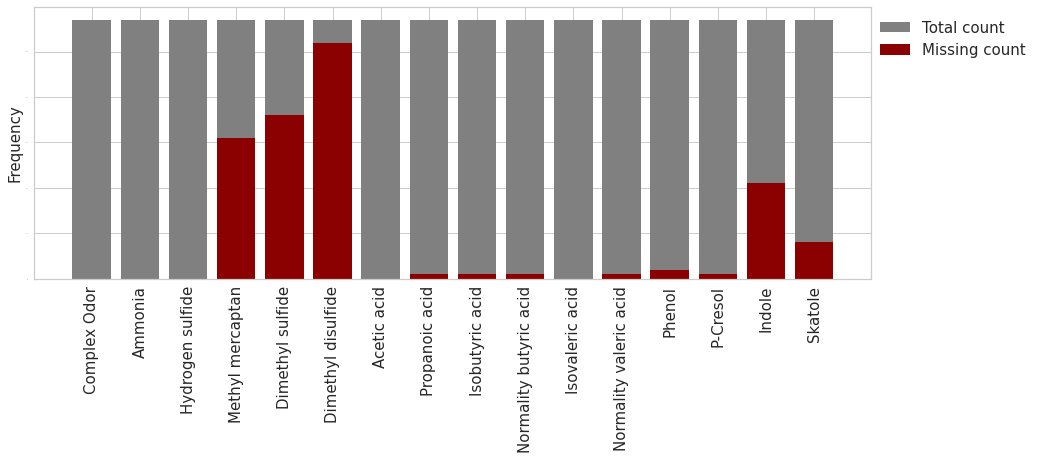

In [8]:
total = nan_odor.count()+nan_odor.isna().sum()

plt.figure(figsize = (15, 5))
plt.bar(nan_odor.columns, total, label = "Total count", color = "grey")
plt.bar(nan_odor.columns, odor.isna().sum(), label = "Nissing count", color = "darkred")
# plt.axhline(total[0]/2, linestyle = "--", color = "black")
plt.xticks(rotation = 90, fontsize = 15) ; plt.yticks(fontsize = 0)
plt.ylabel("Frequency", fontsize = 15)
plt.legend(loc = "upper right", labels = ["Total count", "Missing count"], 
           bbox_to_anchor=(1.2, 1), fontsize = 15)
# plt.title("NaN count", fontsize = 20)
plt.show()

# **변수별 상관관계**

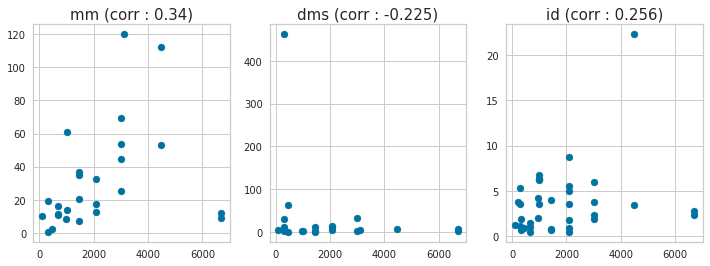

In [9]:
test_variables = ["mm", "dms", "id"]

plt.figure(figsize = (12, 4))
for i in range(len(test_variables)) :
    test_df = odor.loc[:, ["ou", test_variables[i]]].dropna()
    plt.subplot(1,3,i+1)
    corr = np.round(np.corrcoef(test_df.loc[:, "ou"], test_df.loc[:, test_variables[i]])[0,1], 3)
    plt.scatter(odor.loc[:, "ou"], odor.loc[:, test_variables[i]])
    plt.title(test_variables[i] + " (corr : " + str(corr) + ")", fontsize = 15)
    

plt.show()

In [10]:
odor2 = odor.drop(columns = ["dmds"])
print(odor2.shape)
odor2.head(3)

(57, 15)


,ou,nh3,h2s,mm,dms,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


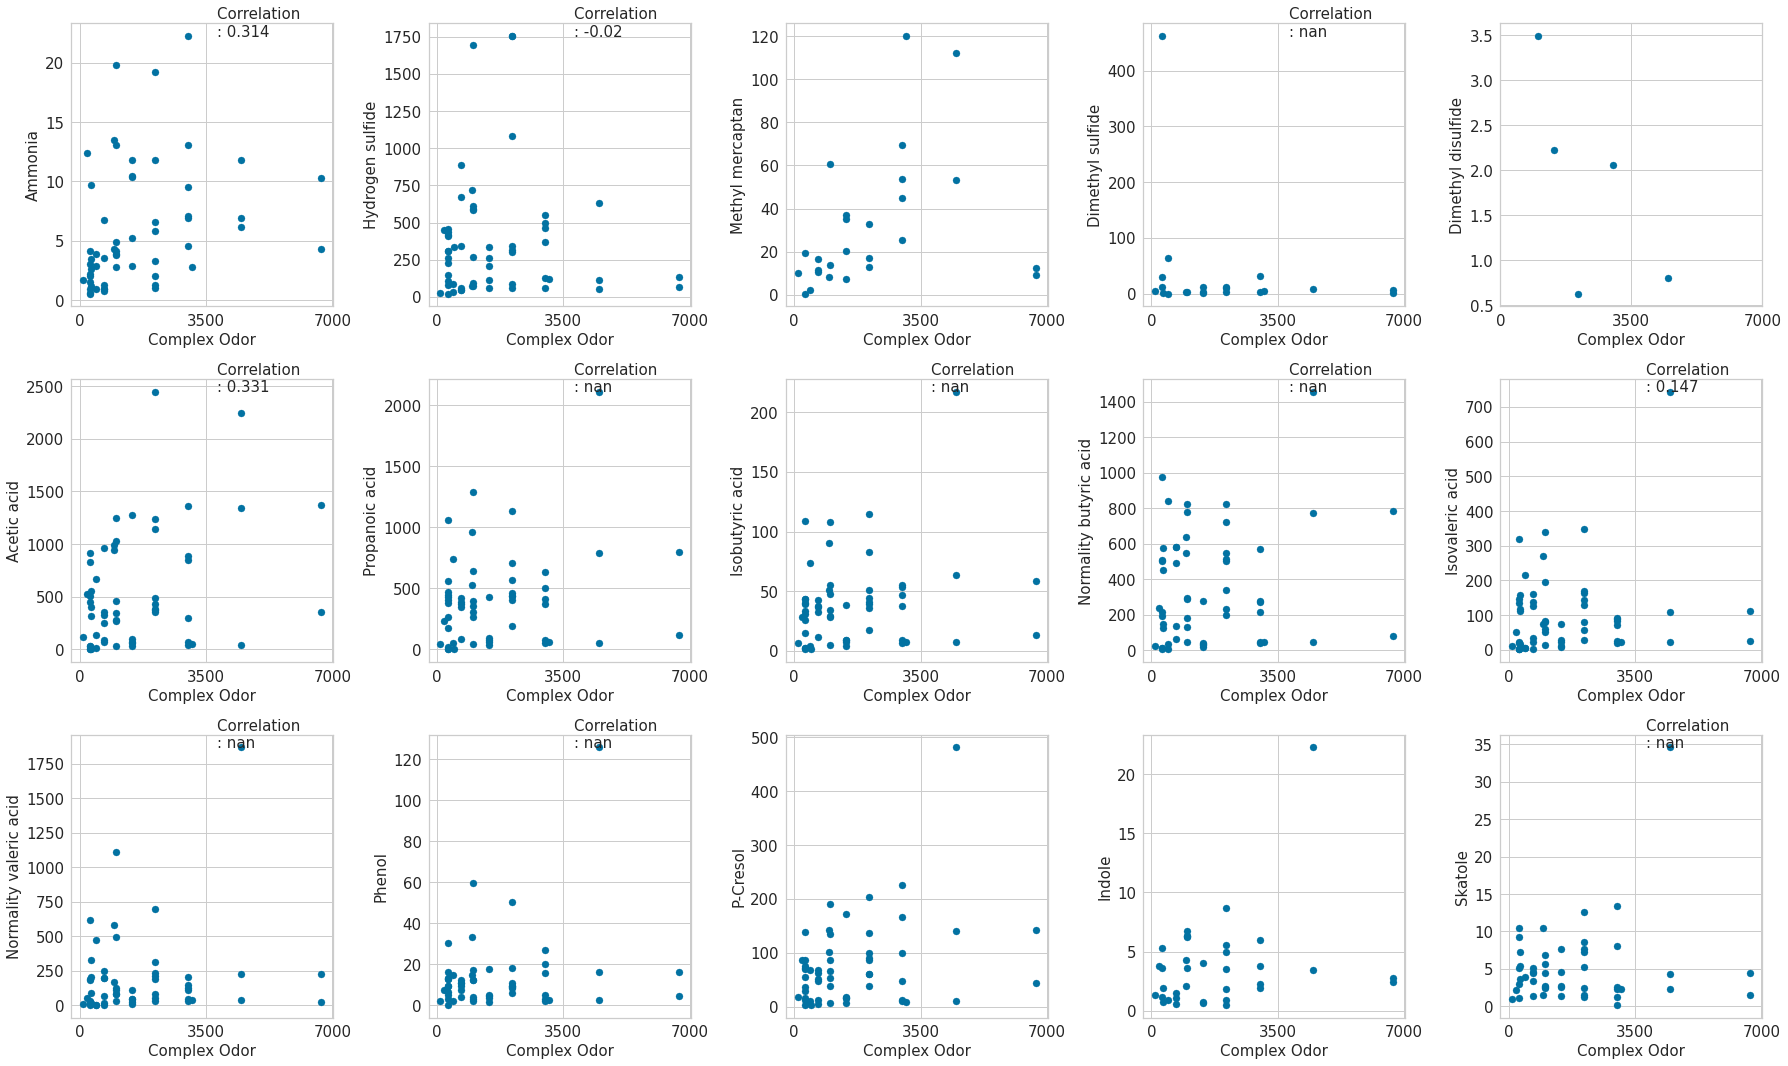

In [11]:
var_name0 = ["Complex Odor", "Ammonia", "Hydrogen sulfide", "Methyl mercaptan", "Dimethyl sulfide", "Dimethyl disulfide", "Acetic acid", "Propanoic acid",
             "Isobutyric acid", "Normality butyric acid", "Isovaleric acid", "Normality valeric acid", "Phenol", "P-Cresol", "Indole", "Skatole"]

plt.figure(figsize = (25, 15))
for i in range(1, len(var_name0)) :
    plt.subplot(3, 5, i)
    plt.scatter(odor.iloc[:,0], odor.iloc[:,i])
    plt.xlabel(var_name0[0], fontsize = 15) ; plt.ylabel(var_name0[i], fontsize = 15)
    plt.text(3800, max(odor.iloc[:,i]),
             "Correlation \n: " + str(np.round(np.corrcoef(odor.iloc[:,0], odor.iloc[:,i])[0,1],3)),
             fontsize = 15)
    plt.xticks([0,3500,7000], [0,3500,7000], fontsize = 15) ; plt.yticks(fontsize = 15)
    
plt.tight_layout()
plt.show()

# **결과 파일 불러오기**

In [81]:
results = pd.read_csv("../OUT/Prediction results (논문용).csv")
display(results.head(3))

,Simple(Mean) Imp_None_Regression,Simple(Mean) Imp_None_Random Forest,Simple(Mean) Imp_None_Extra Tree,Simple(Mean) Imp_None_XGboost,Simple(Mean) Imp_None_DNN,Simple(Mean) Imp_PLS_Regression,Simple(Mean) Imp_PLS_Random Forest,Simple(Mean) Imp_PLS_Extra Tree,Simple(Mean) Imp_PLS_XGboost,Simple(Mean) Imp_PLS_DNN,...,Multivariate(ExtraTree) Imp_PCA_SVR,Multivariate(ExtraTree) Imp_Ridge_SVR,Multivariate(ExtraTree) Imp_Lasso_SVR,Multivariate(ExtraTree) Imp_Elastic net_SVR,KNN Imp_None_SVR,KNN Imp_PLS_SVR,KNN Imp_PCA_SVR,KNN Imp_Ridge_SVR,KNN Imp_Lasso_SVR,KNN Imp_Elastic net_SVR
0,2258.047,761.93,1165.41,644.556030,1644.542969,1204.443,2199.30,2083.8,1608.993042,1676.155029,...,662.782,814.088,543.485,463.491,689.776,616.686,629.886,622.353,597.360,597.360
1,-15957.322,1657.74,1431.90,1370.485962,426.372009,8.498,635.25,669.0,624.158020,2348.813965,...,2118.663,2233.626,1494.362,1338.268,2004.691,2381.776,2009.735,2061.886,2101.963,2101.963
2,1576.157,867.90,1167.71,788.434998,2016.469971,1729.407,1603.50,1162.0,1600.812012,1621.806030,...,1131.443,1213.389,690.436,937.447,1577.005,1937.441,1606.054,1485.458,1048.529,1048.529


## 필요없는 결과 삭제

In [82]:
del_method = []
for i in range(results.shape[1]) :
  if "_Ridge_"  in results.columns[i] or "_Lasso_"  in results.columns[i] or "_Elastic net_"   in results.columns[i] :
      del_method.append(results.columns[i])
del_method
results = results.drop(columns = del_method)
display(results.head(3))

,Simple(Mean) Imp_None_Regression,Simple(Mean) Imp_None_Random Forest,Simple(Mean) Imp_None_Extra Tree,Simple(Mean) Imp_None_XGboost,Simple(Mean) Imp_None_DNN,Simple(Mean) Imp_PLS_Regression,Simple(Mean) Imp_PLS_Random Forest,Simple(Mean) Imp_PLS_Extra Tree,Simple(Mean) Imp_PLS_XGboost,Simple(Mean) Imp_PLS_DNN,...,Simple(Median) Imp_PCA_SVR,Multivariate(BayesianRidge) Imp_None_SVR,Multivariate(BayesianRidge) Imp_PLS_SVR,Multivariate(BayesianRidge) Imp_PCA_SVR,Multivariate(ExtraTree) Imp_None_SVR,Multivariate(ExtraTree) Imp_PLS_SVR,Multivariate(ExtraTree) Imp_PCA_SVR,KNN Imp_None_SVR,KNN Imp_PLS_SVR,KNN Imp_PCA_SVR
0,2258.047,761.93,1165.41,644.556030,1644.542969,1204.443,2199.30,2083.8,1608.993042,1676.155029,...,727.153,956.358,631.046,974.914,692.559,596.152,662.782,689.776,616.686,629.886
1,-15957.322,1657.74,1431.90,1370.485962,426.372009,8.498,635.25,669.0,624.158020,2348.813965,...,2024.666,2027.310,1979.695,2027.239,2099.895,1911.222,2118.663,2004.691,2381.776,2009.735
2,1576.157,867.90,1167.71,788.434998,2016.469971,1729.407,1603.50,1162.0,1600.812012,1621.806030,...,1269.351,1025.033,1113.354,1050.650,1131.806,1648.425,1131.443,1577.005,1937.441,1606.054


# **파이프라인 별 R2 and MAPE**

In [83]:
actual = odor.loc[:,"ou"]
# r2_cal_list = [] ; r2_sk_list = [] ; rmse_list = []
r2_ols_list = []
mape_list = []
mape_list = []

for i in range(results.shape[1]) :
#     rmse_list.append(RMSE(actual, results.iloc[:, i]))
#     r2_cal_list.append(R2(actual, results.iloc[:, i]))
#     r2_sk_list.append(np.round(r2_score(actual, results.iloc[:, i]), 3))
    const_pred_list = sm.add_constant(results.iloc[:, i], has_constant = "add")
    ols = sm.OLS(actual, const_pred_list).fit()
    r2_ols_list.append(np.round(ols.rsquared, 3))
#     mae_list.append(mae(actual, results.iloc[:, i]))
    mape_list.append(MAPE(actual, results.iloc[:, i]))

In [84]:
pd.DataFrame([mape_list, r2_ols_list])

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,264.608,150.897,153.902,153.539,177.562,150.341,167.581,155.652,154.129,191.136,...,103.976,103.892,95.794,103.221,91.191,107.644,88.347,80.805,104.753,77.406
1,0.011,0.155,0.218,0.142,0.061,0.063,0.053,0.070,0.097,0.013,...,0.097,0.112,0.042,0.112,0.167,0.061,0.180,0.256,0.072,0.259


In [85]:
r2_ols_df = pd.DataFrame([r2_ols_list, mape_list], index = ["R2 (ols)", "R2 (mape)"], columns = results.columns).T
sort_r2_ols_df = r2_ols_df.sort_values(by = ["R2 (ols)"], ascending = False)

mape_df = pd.DataFrame([mape_list,r2_ols_list], index = ["R2 (mape)", "R2 (ols)"], columns = results.columns).T
sort_mape_df = mape_df.sort_values(by = ["R2 (mape)"])

display(sort_r2_ols_df.head(3))
display(sort_mape_df.head(3))

,R2 (ols),R2 (mape)
Multivariate(BayesianRidge) Imp_None_Extra Tree,0.342,97.263
KNN Imp_PCA_XGboost,0.289,101.266
KNN Imp_PCA_Random Forest,0.276,116.178


,R2 (mape),R2 (ols)
KNN Imp_PCA_SVR,77.406,0.259
KNN Imp_None_SVR,80.805,0.256
Multivariate(ExtraTree) Imp_PCA_SVR,88.347,0.180


## **결과순 정렬**

In [86]:
rank = 10
best_models_df = pd.DataFrame([sort_r2_ols_df.index[:rank], sort_r2_ols_df.iloc[:rank, 0], sort_r2_ols_df.iloc[:rank, 1],
                               sort_mape_df.index[:rank], sort_mape_df.iloc[:rank, 0], sort_mape_df.iloc[:rank, 1]],
                               index = ["R2 (ols)", "R2 (ols) value", "mape value", "mape", "mape value", "R2 (ols) value"]).T
best_models_df
# best_models = list(set(best_models_df.iloc[:, 0]) & set(best_models_df.iloc[:, 3]))
r2_best_models = list(best_models_df.iloc[0:3, 0])
mape_best_models = list(best_models_df.iloc[0:3, 3])
# print(best_models) ; print(r2_best_models)

In [87]:
# color_at_df(best_models_df, r2_best_models + mape_best_models, "pink")

In [88]:
# best_results = results.loc[:, best_models+r2_best_models+mape_best_models]
best_results = results.loc[:, r2_best_models+mape_best_models]
print(best_results.shape)
display(best_results.head(3))

(57, 6)


,Multivariate(BayesianRidge) Imp_None_Extra Tree,KNN Imp_PCA_XGboost,KNN Imp_PCA_Random Forest,KNN Imp_PCA_SVR,KNN Imp_None_SVR,Multivariate(ExtraTree) Imp_PCA_SVR
0,757.75,528.776978,530.76,629.886,689.776,662.782
1,989.20,1008.890991,1483.14,2009.735,2004.691,2118.663
2,630.95,1538.160034,2108.77,1606.054,1577.005,1131.443


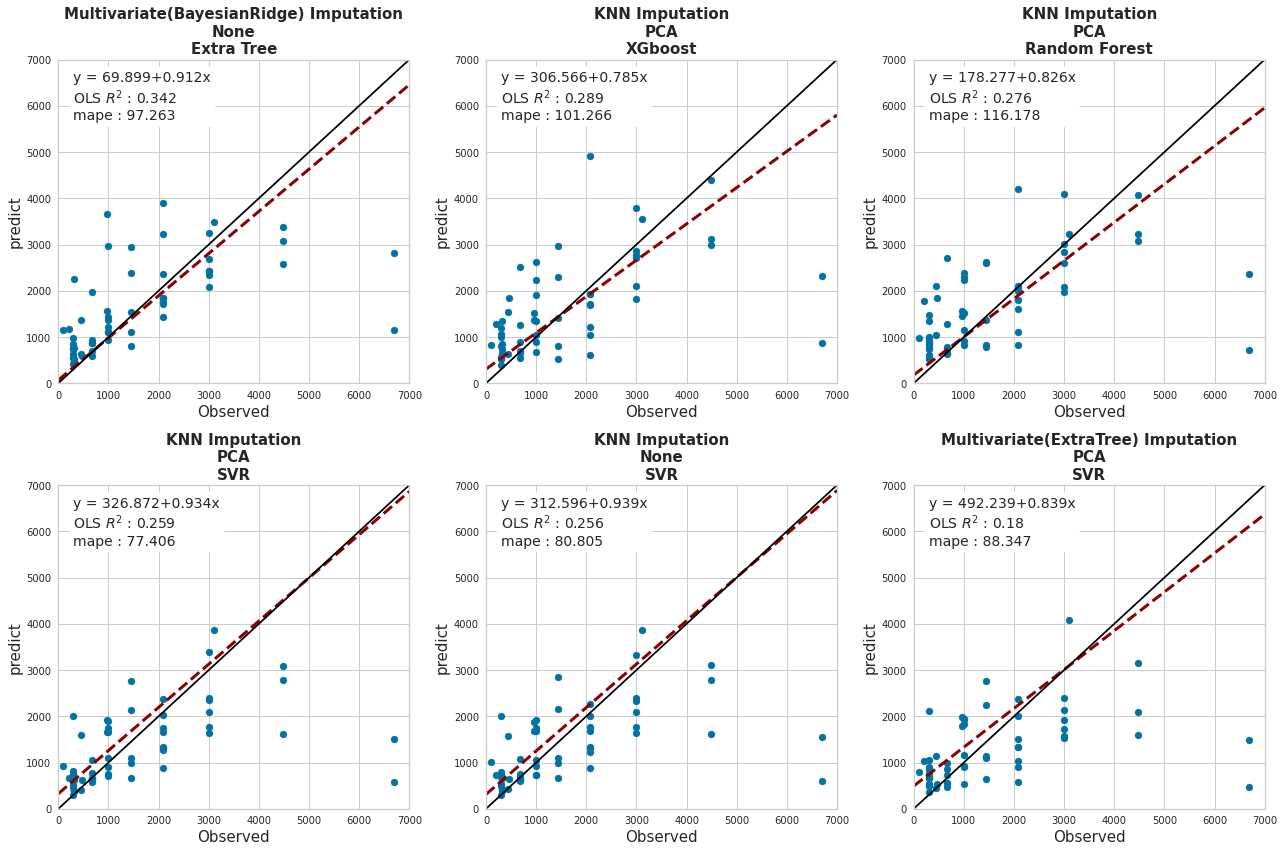

In [90]:
title = [best_results.columns[i].replace("_", "\n").replace("Imp", "Imputation") for i in range(best_results.shape[1])]

plt.figure(figsize = (18, 12))
for i in range(best_results.shape[1]) :
    const_pred_list = sm.add_constant(best_results.iloc[:, i], has_constant = "add")
    pred_ols = sm.OLS(actual, const_pred_list).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x
    
    plt.subplot(2, 3, i+1)
    plt.scatter(actual, best_results.iloc[:, i])
    plt.xlim(0, 7000) ; plt.ylim(0, 7000)
    plt.plot(linear_x, linear_y, color = "darkred", linestyle = "--", linewidth = 3)
    plt.plot([0, 7000], [0, 7000], color = "black")
    plt.xlabel("Observed", fontsize = 15)  ; plt.ylabel("predict", fontsize = 15)
    plt.title(title[i], 
              fontsize = 15, weight = "bold")
    plt.text(300, 5700,
             "y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
             "\nOLS " + r"$R^2$" + " : " + str(np.round(pred_ols.rsquared, 3)) +
             "\nmape : " + str(MAPE(actual, best_results.iloc[:, i])),
             fontsize = 14,
             bbox = dict(facecolor = 'white', edgecolor = 'none', boxstyle = 'round'))

plt.tight_layout()
plt.show()

In [89]:
r2_best_results = results.loc[:, r2_best_models]
r2_result_mean = pd.DataFrame(r2_best_results.mean(axis = 1), columns = ["mean"])
r2_best_results = pd.concat([r2_best_results, r2_result_mean], axis = 1)
print(r2_best_results.shape)
display(r2_best_results.head(3))

(57, 4)


,Multivariate(BayesianRidge) Imp_None_Extra Tree,KNN Imp_PCA_XGboost,KNN Imp_PCA_Random Forest,mean
0,757.75,528.776978,530.76,605.762326
1,989.20,1008.890991,1483.14,1160.410330
2,630.95,1538.160034,2108.77,1425.960011


# **Prediction vs Observation plot**

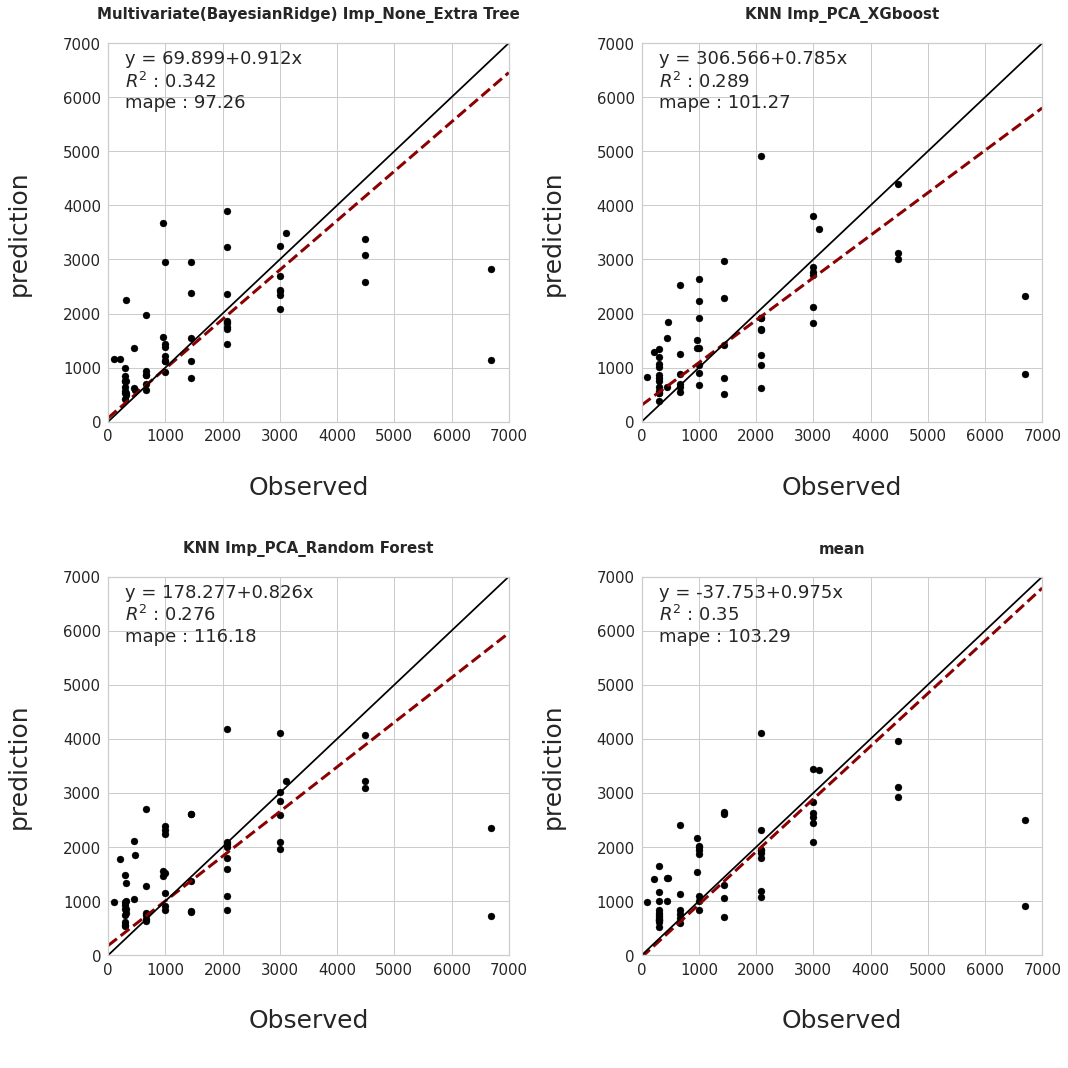

In [72]:
plt.figure(figsize = (15, 15))
mape2 = [str(MAPE(actual, r2_best_results.iloc[:, i])) for i in range(r2_best_results.shape[1])]

for i in range(r2_best_results.shape[1]) :
    const_pred_list = sm.add_constant(r2_best_results.iloc[:, i], has_constant = "add")
    pred_ols = sm.OLS(actual, const_pred_list).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x
    
    plt.subplot(2, 2, i+1)
    plt.scatter(actual, r2_best_results.iloc[:, i], color = "black")
    plt.xlim(0, 7000) ; plt.ylim(0, 7000)
    plt.plot(linear_x, linear_y, color = "darkred", linestyle = "--", linewidth = 3)
    plt.plot([0, 7000], [0, 7000], color = "black")
    plt.xlabel("\nObserved\n", fontsize = 25)  ; plt.ylabel("prediction\n", fontsize = 25)
    plt.xticks(fontsize = 15)  ; plt.yticks(fontsize = 15)
    plt.title(r2_best_results.columns[i] + "\n", 
              fontsize = 15, weight = "bold")

    plt.text(300, 5800,
             "y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
             "\n$R^2$" + " : " + str(np.round(pred_ols.rsquared, 3)) + 
             "\nmape : " + str(np.round(MAPE(actual, r2_best_results.iloc[:, i]), 2)),
             fontsize = 18,
#              weight = "bold",
             bbox = dict(facecolor = "white", edgecolor = 'none', boxstyle = 'round', alpha = 0))

plt.tight_layout()
plt.show()

# **====================== 추가 분석 ======================**

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.experimental import enable_iterative_imputer

import time
from yellowbrick.target import FeatureCorrelation
from sklearn.decomposition import PCA
from itertools import accumulate
from sklearn.preprocessing import StandardScaler

# **Imputation and Correlation**

In [23]:
var_name = ["Complex Odor", "Ammonia", "Hydrogen sulfide", "Methyl mercaptan", "Dimethyl sulfide", "Acetic acid", "Propanoic acid", 
            "Isobutyric acid", "Normality butyric acid", "Isovaleric acid", "Normality valeric acid", "Phenol", "P-Cresol", "Indole", "Skatole"]

In [24]:
data = odor2.copy()

# """< Missing Value and Data set >"""
start = time.time()
imp_data1 = SimpleImputer(strategy = "mean").fit_transform(data)
uv_mean_data = pd.DataFrame(imp_data1, columns = data.columns)
print("time :", time.time() - start) 

start = time.time()
imp_data2 = SimpleImputer(strategy = "median").fit_transform(data)
uv_median_data = pd.DataFrame(imp_data2, columns = data.columns)
print("time :", time.time() - start) 

start = time.time()
imp_data3 = IterativeImputer(max_iter = 1000, estimator = BayesianRidge(), min_value = 0, random_state = 99).fit_transform(data)
mv_br_data = pd.DataFrame(imp_data3, columns = data.columns)
print("time :", time.time() - start) 

start = time.time()
imp_data4 = IterativeImputer(max_iter = 1000, estimator = ExtraTreesRegressor(), min_value = 0, random_state = 99).fit_transform(data)
mv_et_data = pd.DataFrame(imp_data4, columns = data.columns)
print("time :", time.time() - start) 

start = time.time()
imp_data5 = IterativeImputer(max_iter = 1000, estimator = BayesianRidge(), sample_posterior = True, min_value = 0, random_state = 99).fit_transform(data)
mul_br_data = pd.DataFrame(imp_data5, columns = data.columns)
print("time :", time.time() - start) 

start = time.time()
imp_data6 = IterativeImputer(max_iter = 1000, estimator = GaussianProcessRegressor(), sample_posterior = True, min_value = 0, random_state = 99).fit_transform(data)
mul_gp_data = pd.DataFrame(imp_data6, columns = data.columns)
print("time :", time.time() - start) 

start = time.time()
imp_data7 = KNNImputer().fit_transform(data)
knn_data = pd.DataFrame(imp_data7, columns = data.columns)
print("time :", time.time() - start) 

time : 0.00321197509765625
time : 0.0038106441497802734
time : 0.2976374626159668


/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


time : 992.661878824234
time : 53.87210273742676
time : 37.511943101882935
time : 0.014010190963745117


In [25]:
start = time.time()
imp_data3 = IterativeImputer(max_iter = 1000, estimator = BayesianRidge(), min_value = 0, random_state = 99).fit_transform(data)
mv_br_data = pd.DataFrame(imp_data3, columns = data.columns)
print("time :", time.time() - start)  

start = time.time()
imp_data7 = KNNImputer().fit_transform(data)
knn_data = pd.DataFrame(imp_data7, columns = data.columns)
print("time :", time.time() - start)  

time : 0.24460363388061523
time : 0.005617618560791016


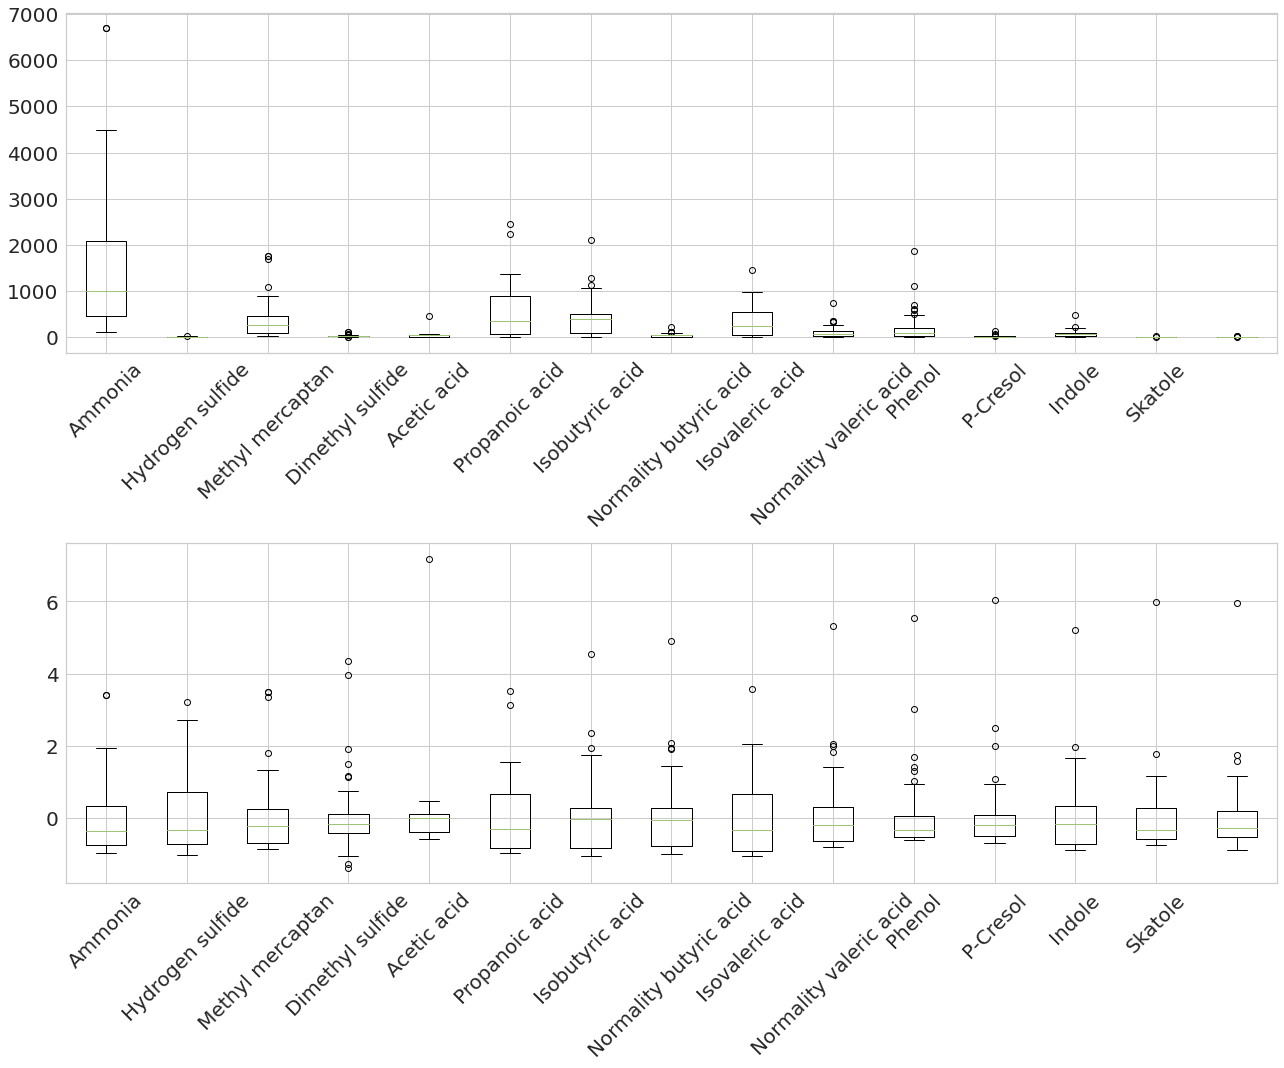

In [26]:

plt.figure(figsize = (18, 15))

plt.subplot(2,1,1)
plt.boxplot(mv_br_data)
plt.xticks(list(range(1,15)), var_name[1:], rotation = 45, fontsize = 20) ; plt.yticks(fontsize = 20)
# plt.title("Boxplot for MI by bayesian ridge imputed data\n", fontsize = 15) # ;plt.xlabel("Features", fontsize = 15)


plt.subplot(2,1,2)
plt.boxplot(StandardScaler().fit_transform(mv_br_data))
plt.xticks(list(range(1,15)), var_name[1:], rotation = 45, fontsize = 20) ; plt.yticks(fontsize = 20)
# plt.title("Boxplot for MI by bayesian ridge imputed data\n", fontsize = 15) # ;plt.xlabel("Features", fontsize = 15)


plt.tight_layout()
plt.show()

In [27]:
uv_mean_corr = uv_mean_data.corr()
uv_median_corr = uv_median_data.corr()
mv_br_corr = mv_br_data.corr()
mv_et_corr = mv_et_data.corr()
mul_br_corr = mul_br_data.corr()
mul_gp_corr = mul_gp_data.corr()
knn_corr = knn_data.corr()

In [31]:
mv_br_corr.index = var_name
mv_br_corr.columns = var_name
knn_corr.index = var_name
knn_corr.columns = var_name

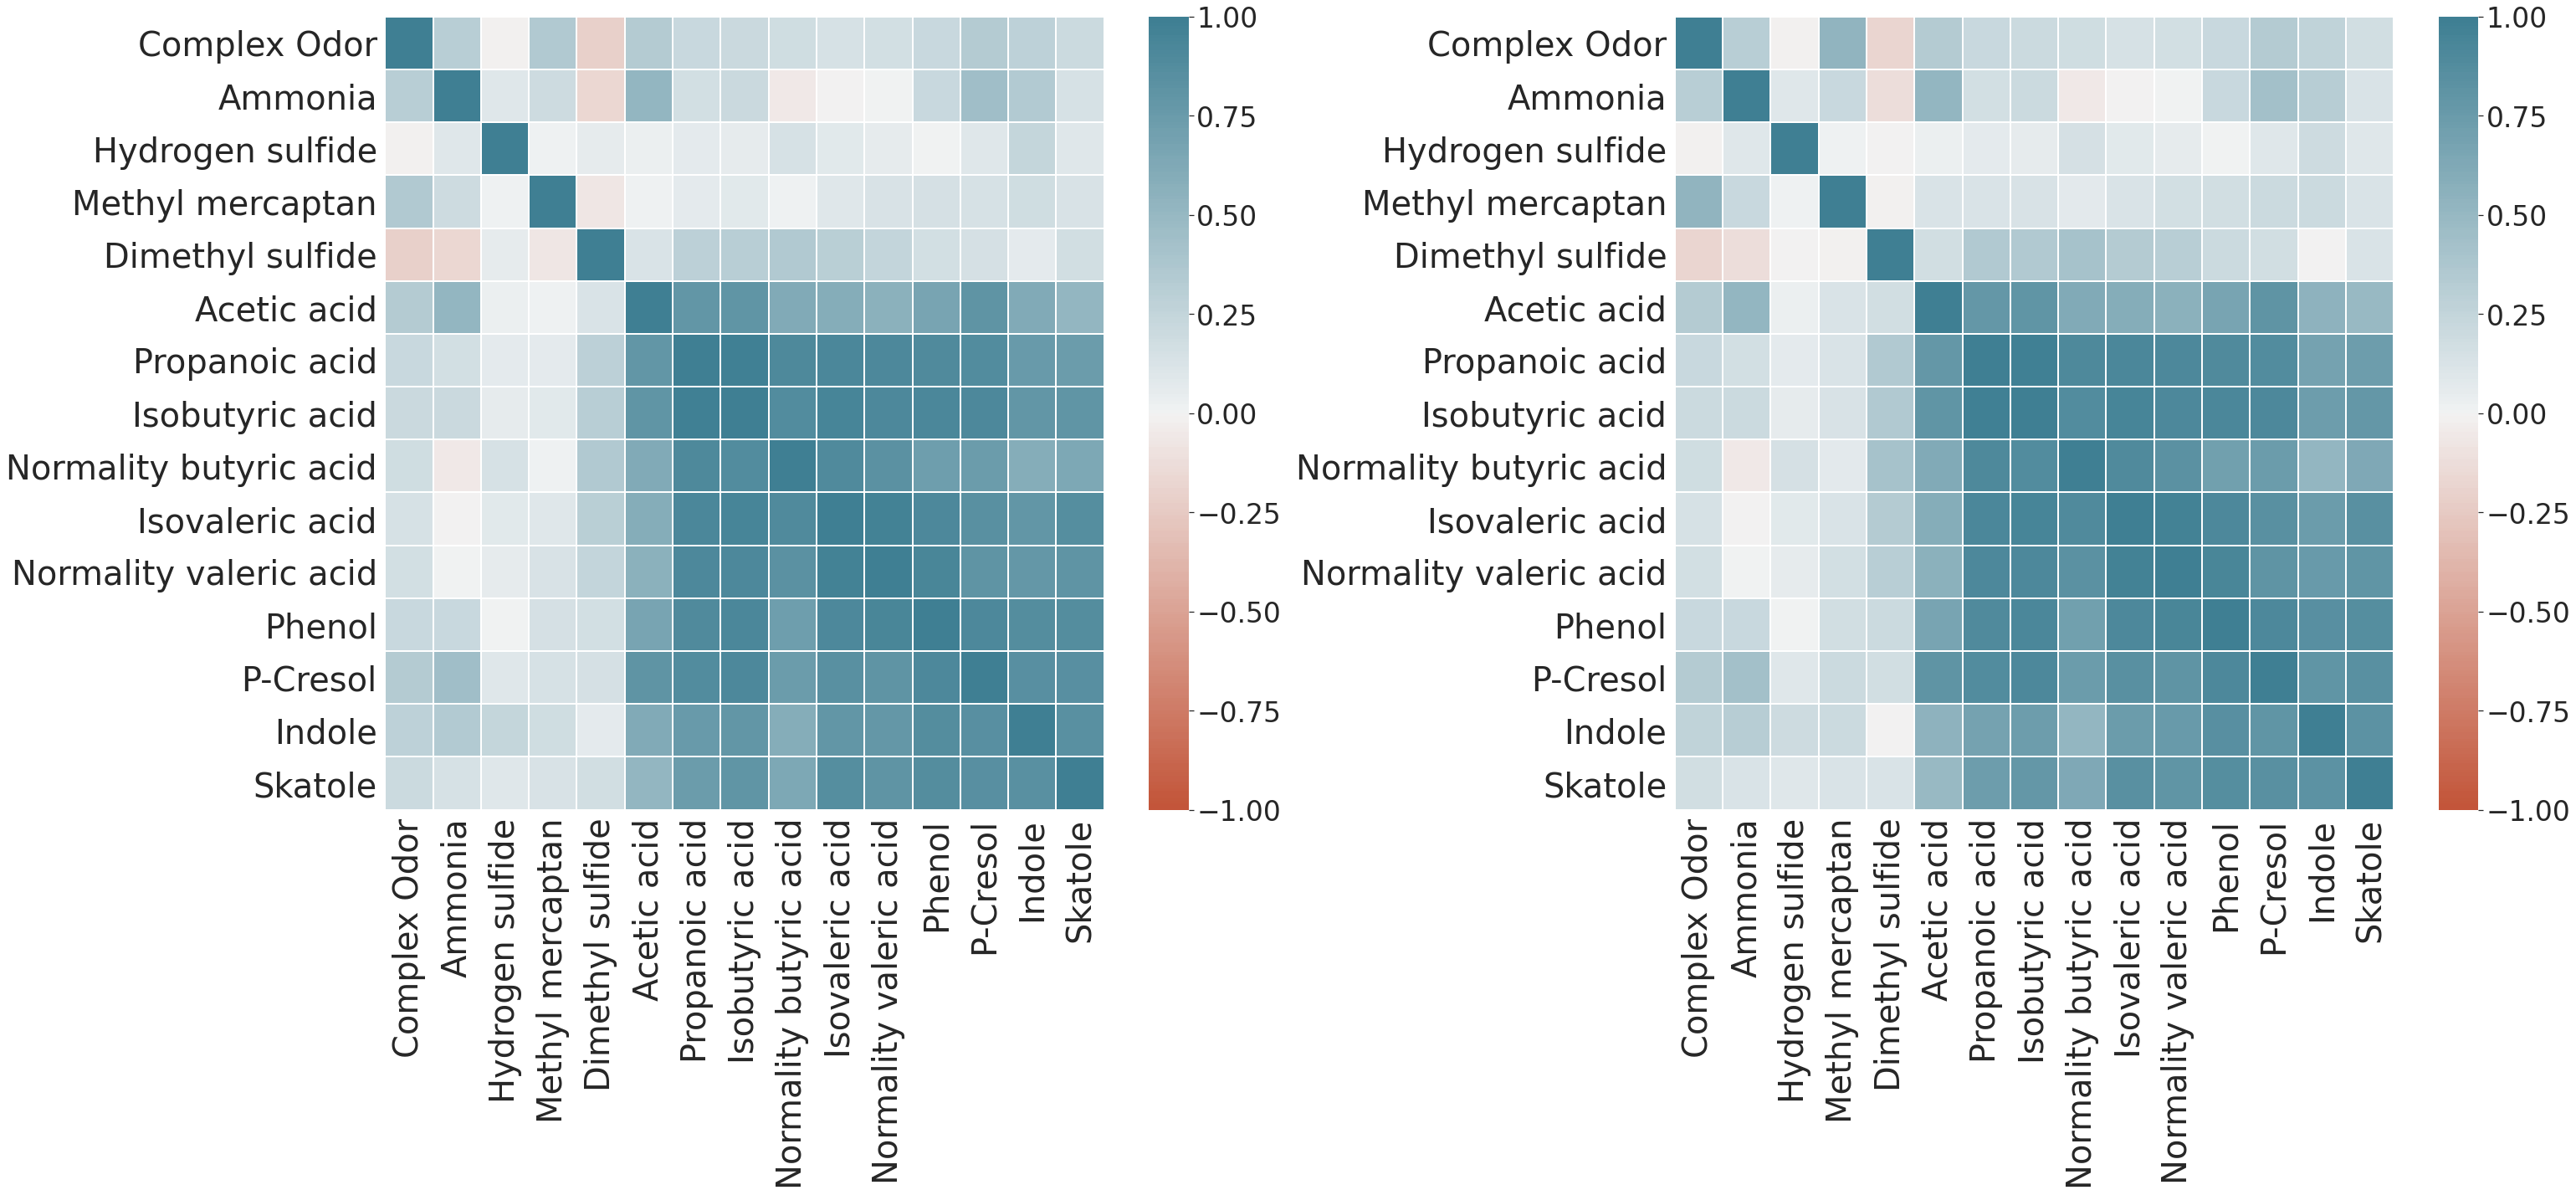

In [83]:
plt.figure(figsize = (43,20))

plt.subplot(1, 2, 1)
sns.set(font_scale = 3)
sns.heatmap(mv_br_corr, vmin = -1, vmax = 1, center = 0,  #mask = mask,
            cmap = sns.diverging_palette(20, 220, n=200), linewidths = .3, annot = False)
plt.xticks(fontsize = 40) ; plt.yticks(fontsize = 40)
# plt.title("Heatmap Compelete data\nby Multivariate imputation (Bayesian Rdige)\n", fontsize = 20)

plt.subplot(1, 2, 2)
sns.set(font_scale = 3)
sns.heatmap(knn_corr, vmin = -1, vmax = 1, center = 0, #mask = mask,
            cmap = sns.diverging_palette(20, 220, n=200), linewidths = .3, annot = False)
plt.xticks(fontsize = 40) ; plt.yticks(fontsize = 40)
# plt.title("Heatmap Compelete data\nby KNN imputation\n", fontsize = 20)
sns.set(font_scale = 1)

plt.tight_layout()
plt.show()

In [35]:
mv_br_data.columns = var_name
knn_data.columns = var_name

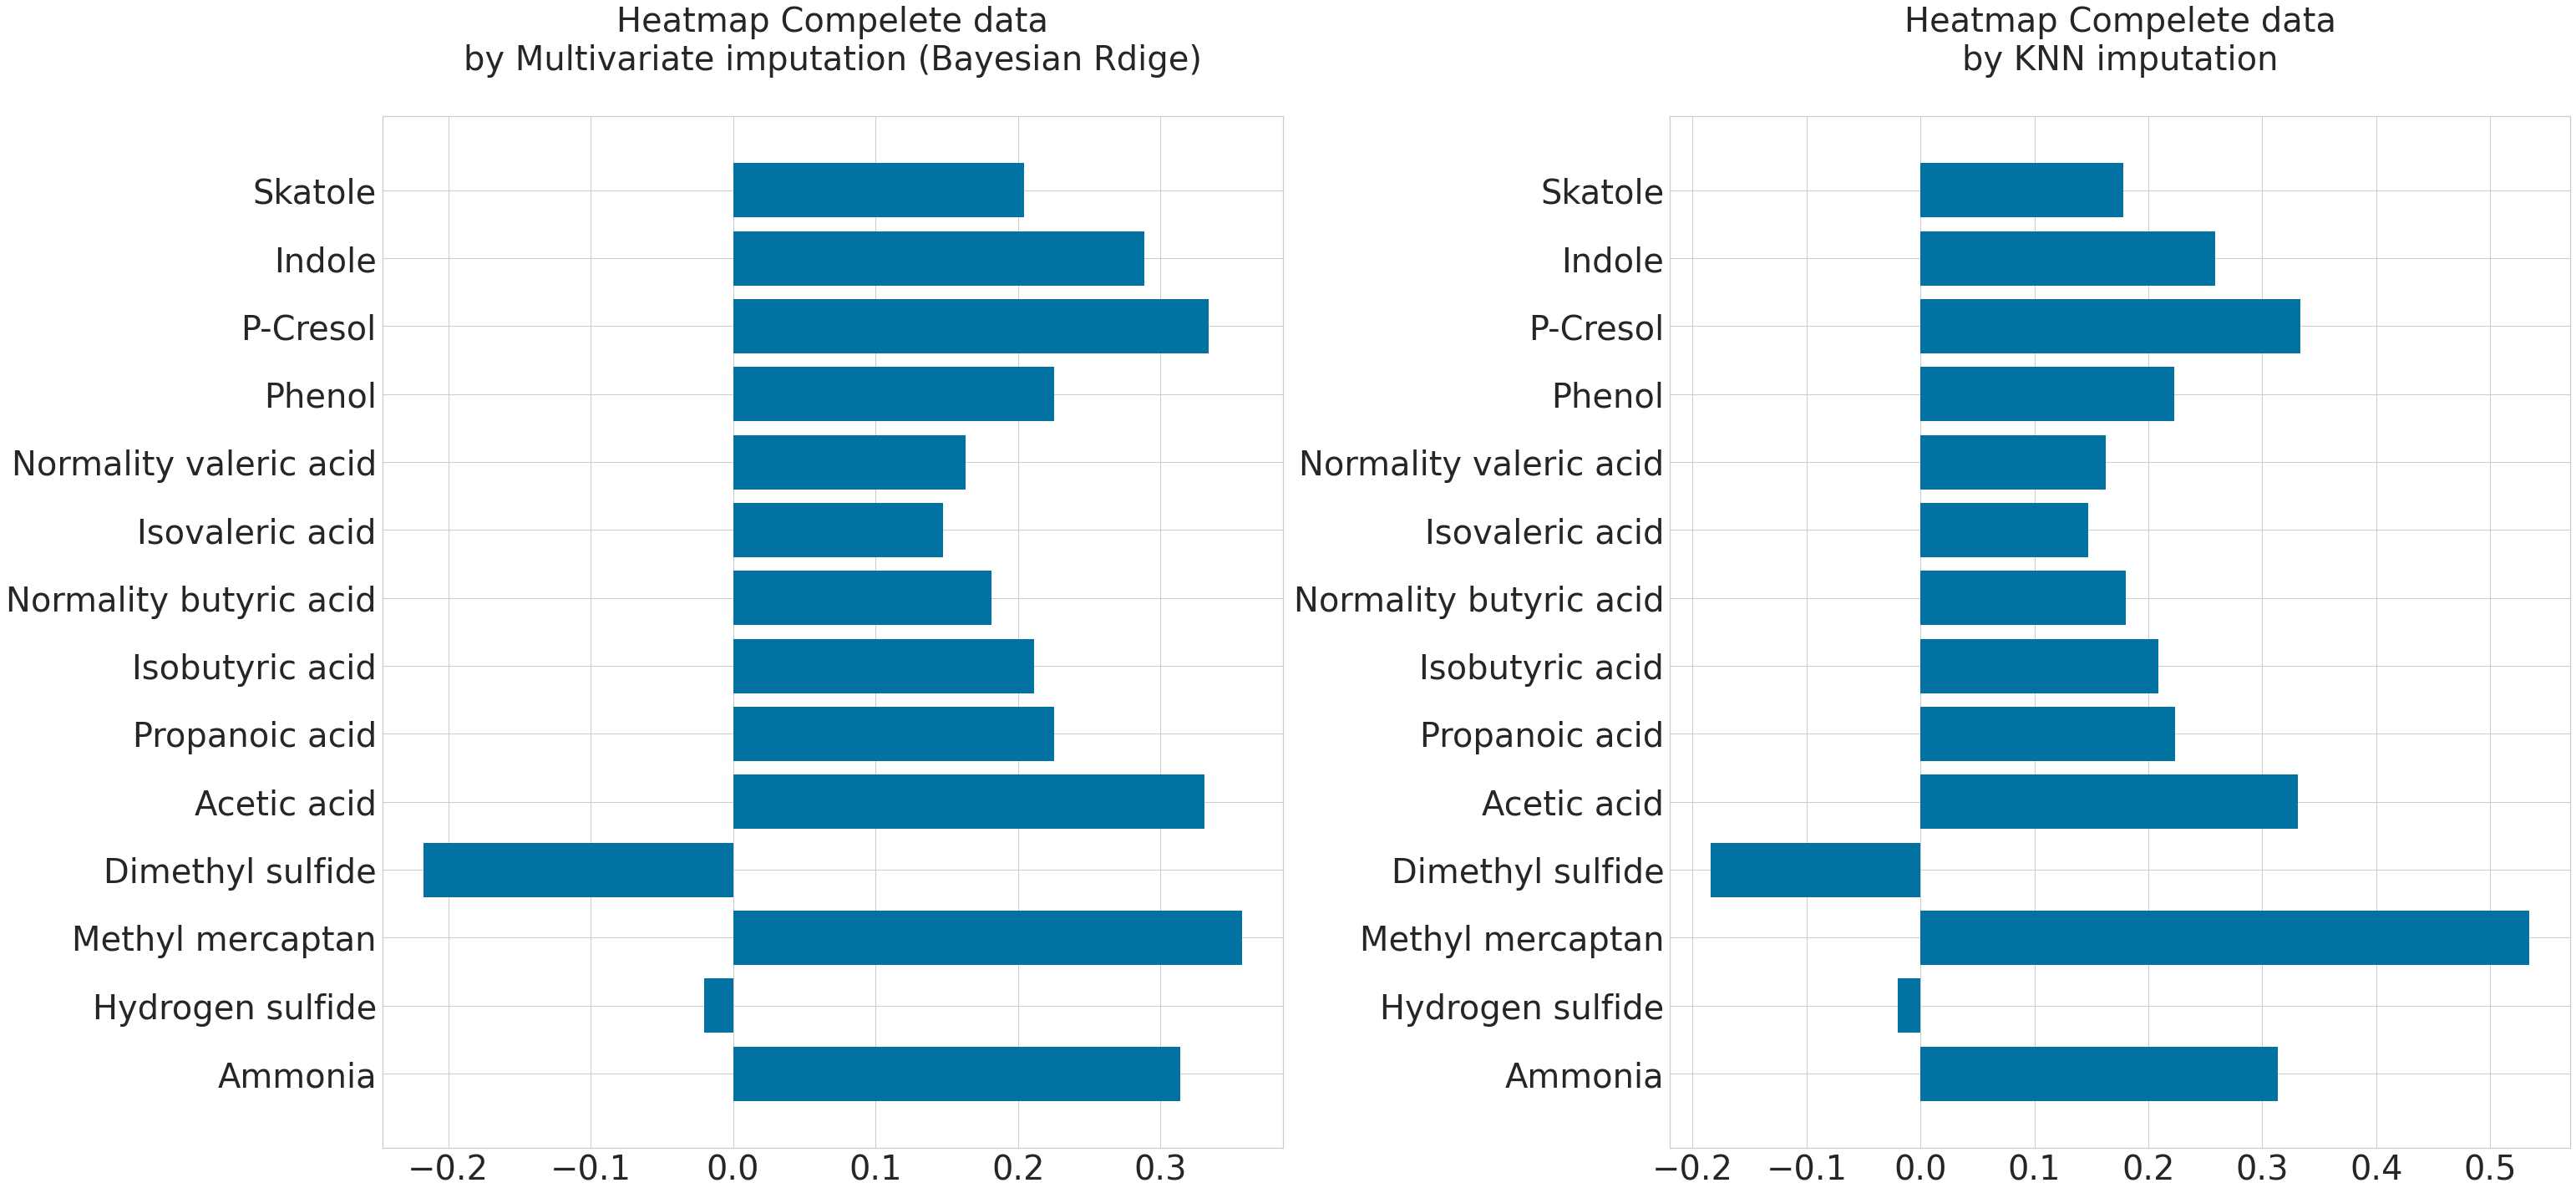

In [42]:
plt.figure(figsize = (43,20))

plt.subplot(1, 2, 1)
### Feature correlation
X, y = mv_br_data.drop(columns = ["Complex Odor"]), mv_br_data["Complex Odor"]

# Create a list of the feature names
features = np.array(X.columns)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels = features)
plt.title("Heatmap Compelete data\nby Multivariate imputation (Bayesian Rdige)\n", fontsize = 40)
plt.xticks(fontsize = 40) ; plt.yticks(fontsize = 40)
visualizer.fit(X, y);

plt.subplot(1, 2, 2)
### Feature correlation
X, y = knn_data.drop(columns = ["Complex Odor"]), mv_br_data["Complex Odor"]

# Create a list of the feature names
features = np.array(X.columns)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels = features)
plt.xticks(fontsize = 40) ; plt.yticks(fontsize = 40)
plt.title("Heatmap Compelete data\nby KNN imputation\n", fontsize = 40)
visualizer.fit(X, y)

plt.tight_layout();

In [25]:
# corr_df = pd.concat([np.round(multivar_corr.iloc[0,:], 3), np.round(knn_corr.iloc[0,:], 3)], axis = 1).T
# corr_df.index = ["multivar", "knn"]
# display(corr_df)

# sort_multivar_corr = pd.DataFrame(np.round(multivar_corr.iloc[0,:], 3)).sort_values(by = ["OU"]).T
# display(sort_multivar_corr)

# sort_knn_corr = pd.DataFrame(np.round(knn_corr.iloc[0,:], 3)).sort_values(by = ["OU"]).T
# display(sort_knn_corr)

In [26]:
corr_df = pd.DataFrame(columns = var_name).T
corr_list = [uv_mean_corr, uv_median_corr, mv_br_corr, mv_et_corr, mul_br_corr, mul_gp_corr, knn_corr]

for i in range(len(corr_list)) : 
    corr_list[i].columns = var_name
    corr_df = pd.concat([corr_df, np.round(corr_list[i].iloc[0,:], 3)], axis = 1)
corr_df

,ou,ou,ou,ou,ou,ou,ou
OU,1.000,1.000,1.000,1.000,1.000,1.000,1.000
Ammonia,0.314,0.314,0.314,0.314,0.314,0.314,0.314
Hydrogen sulfide,-0.020,-0.020,-0.020,-0.020,-0.020,-0.020,-0.020
Methyl mercaptan,0.272,0.361,0.357,0.462,0.335,0.420,0.535
Dimethyl sulfide,-0.173,-0.125,-0.217,-0.030,-0.141,-0.116,-0.184
Acetic acid,0.331,0.331,0.331,0.331,0.331,0.331,0.331
Propanoic acid,0.218,0.218,0.225,0.221,0.226,0.227,0.223
Isobutyric acid,0.203,0.204,0.211,0.208,0.212,0.213,0.209
Normality butyric acid,0.174,0.177,0.181,0.181,0.181,0.184,0.180
Isovaleric acid,0.147,0.147,0.147,0.147,0.147,0.147,0.147


In [33]:
corr_index_df = pd.DataFrame(index = range(corr_df.shape[0]))
for i in range(corr_df.shape[1]) :
    a = pd.DataFrame(abs(corr_df.iloc[:,i]).sort_values().index)
    corr_index_df = pd.concat([corr_index_df, a], axis = 1)
corr_index_df

,0,0,0,0,0,0,0
0,Hydrogen sulfide,Hydrogen sulfide,Hydrogen sulfide,Hydrogen sulfide,Hydrogen sulfide,Hydrogen sulfide,Hydrogen sulfide
1,Isovaleric acid,Dimethyl sulfide,Isovaleric acid,Dimethyl sulfide,Dimethyl sulfide,Dimethyl sulfide,Isovaleric acid
2,Skatole,Isovaleric acid,Normality valeric acid,Isovaleric acid,Isovaleric acid,Isovaleric acid,Normality valeric acid
3,Normality valeric acid,Normality valeric acid,Normality butyric acid,Normality valeric acid,Normality valeric acid,Normality valeric acid,Skatole
4,Dimethyl sulfide,Skatole,Skatole,Normality butyric acid,Skatole,Normality butyric acid,Normality butyric acid
5,Normality butyric acid,Normality butyric acid,Isobutyric acid,Skatole,Normality butyric acid,Isobutyric acid,Dimethyl sulfide
6,Isobutyric acid,Isobutyric acid,Dimethyl sulfide,Isobutyric acid,Indole,Phenol,Isobutyric acid
7,Phenol,Phenol,Propanoic acid,Propanoic acid,Isobutyric acid,Skatole,Propanoic acid
8,Propanoic acid,Propanoic acid,Phenol,Phenol,Phenol,Propanoic acid,Phenol
9,Indole,Indole,Indole,Indole,Propanoic acid,Indole,Indole


## **Scatter plot**

In [266]:
# plt.figure(figsize = (35, 18))
# for i in range(1, len(var_name)) :
#     plt.subplot(3, 5, i)
#     plt.scatter(mv_br_data.iloc[:,0], mv_br_data.iloc[:,i])
#     plt.xlabel(var_name[0], fontsize = 25) ; plt.ylabel(var_name[i], fontsize = 25)
#     plt.text(4300, max(mv_br_data.iloc[:,i])*0.85,
#              "Correlation \n: " + str(np.round(np.corrcoef(mv_br_data.iloc[:,0], mv_br_data.iloc[:,i])[0,1],3)),
#              fontsize = 25)
#     plt.xticks([0,3500,7000], [0,3500,7000], fontsize = 20) ; plt.yticks(fontsize = 20)
    
# plt.tight_layout()
# plt.show()

In [267]:
# plt.figure(figsize = (35, 18))
# for i in range(1, len(var_name0)) :
#     plt.subplot(3, 5, i)
#     plt.scatter(odor.iloc[:,0], odor.iloc[:,i])
#     plt.xlabel(var_name0[0], fontsize = 25) ; plt.ylabel(var_name0[i], fontsize = 25)
# #     plt.text(4300, max(odor.iloc[:,i])*0.85,
# #              "Correlation \n: " + str(np.round(np.corrcoef(odor.iloc[:,0], odor.iloc[:,i])[0,1],3)),
# #              fontsize = 25)
#     plt.xticks([0,3500,7000], [0,3500,7000], fontsize = 20) ; plt.yticks(fontsize = 20)
    
# plt.tight_layout()
# plt.show()

# **PCA**

In [140]:
mv_br_X = mv_br_data.iloc[:,1:]
st_mv_br_X = pd.DataFrame(StandardScaler().fit_transform(mv_br_X), columns = mv_br_X.columns)
mv_br_y = mv_br_data.iloc[:,0]

pca = PCA(n_components = st_mv_br_X.shape[1], random_state = 99).fit(st_mv_br_X)
cum_var = list(accumulate(pca.explained_variance_ratio_)) 
pca_idx = np.where(np.array(cum_var) > 0.85)[0][0] + 1

pca = PCA(n_components = pca_idx, random_state = 99).fit(st_mv_br_X)
new_mv_br_X = pd.DataFrame(pca.transform(st_mv_br_X), columns = ["comp" + str(i) for i in range(pca_idx)])
display(new_mv_br_X.head())

,comp0,comp1,comp2,comp3
0,-2.605629,0.543763,-0.428002,0.568942
1,4.573635,4.938076,0.571503,-1.575645
2,1.451935,1.846208,-0.797783,0.006927
3,0.984765,0.836890,0.103975,0.597990
4,0.213466,1.202805,-0.089237,0.172065


[0.605 0.115 0.075 0.073]
[0.605 0.719 0.794 0.867 0.926 0.963 0.975 0.986 0.993 0.996 0.998 0.999
 1.    1.   ]


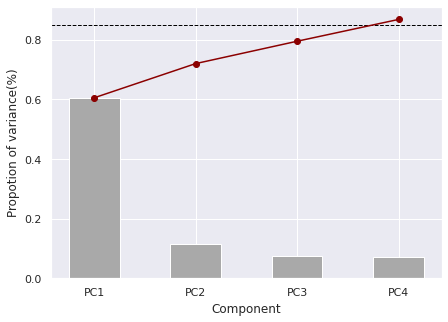

In [141]:
plt.figure(figsize = (7,5))

print(np.round(pca.explained_variance_ratio_, 3))
print(np.round(cum_var, 3))

plt.bar(x =list(range(0,4)), height = pca.explained_variance_ratio_,
        width = 0.5,
        color = "darkgrey")
plt.axhline(0.85, color = "black", linestyle = "--", linewidth = 1)
plt.plot(cum_var[:pca_idx], marker = "o", color = "darkred")
plt.xticks(list(range(0,4)), ["PC"+str(i) for i in list(range(1, pca_idx+1))])
plt.xlabel("Component") ; plt.ylabel("Propotion of variance(%)")

plt.show()

In [144]:
# !pip install bioinfokit

In [197]:
bi_col = ['OC', '$NH_3$', '$H_2S$', 'MM', 'DMS', 'ACA', 'PPA', 'IBA', 'BTA', 'IVA', 'VLA', 'PH', 'PC', 'ID', 'SK']

In [198]:
from bioinfokit.visuz import cluster
pca_scores = pca.transform(st_mv_br_X)
loadings = pca.components_

sns.set(font_scale = 0.5)
sns.set_context('paper')
cluster.biplot(cscore = pca_scores, loadings = loadings, 
               colordot = "black", 
#                labels = [mv_br_data.columns[i].upper() for i in range(len(mv_br_data.columns))], 
               labels = bi_col,
               var1 = round(pca.explained_variance_ratio_[0]*100, 2),
               var2 = round(pca.explained_variance_ratio_[1]*100, 2))

# cluster.biplot(cscore = pca_scores, loadings = loadings, 
#                labels = [mv_br_data.columns[i].upper() for i in range(len(mv_br_data.columns))], 
#                var1 = round(pca.explained_variance_ratio_[0]*100, 2),
#                var2 = round(pca.explained_variance_ratio_[1]*100, 2),
#                var3 = round(pca.explained_variance_ratio_[2]*100, 2))
sns.set_context('notebook')
sns.set(font_scale = 1)

In [170]:
loadings = pca.components_
pca_load_df = pd.DataFrame(np.round(loadings, 3), columns = var_name[1:], index = ["PC"+str(i) for i in list(range(1, pca_idx+1))]).T
pca_load_df

,PC1,PC2,PC3,PC4
Ammonia,0.080,-0.672,0.000,-0.310
Hydrogen sulfide,0.038,-0.062,0.949,-0.114
Methyl mercaptan,0.045,-0.300,0.086,0.762
Dimethyl sulfide,0.092,0.448,0.144,-0.220
Acetic acid,0.263,-0.248,-0.148,-0.383
Propanoic acid,0.331,0.075,-0.062,-0.085
Isobutyric acid,0.337,0.043,-0.064,-0.076
Normality butyric acid,0.294,0.251,0.054,-0.054
Isovaleric acid,0.328,0.179,0.003,0.121
Normality valeric acid,0.321,0.149,-0.019,0.173


# **Variable Importance**

In [43]:
multivar_result = Odor(data = odor2, missing = "Multivariate(BayesianRidge) Imp", Variable = "None", Model = "Extra Tree")
multivar_var = multivar_result["use var"]
multivar_importance = multivar_result["importance"]
multivar_importance.columns = list(range(odor2.shape[0]))
multivar_data = multivar_result["imp data"]
multivar_data.columns = var_name


knn_result1 = Odor(data = odor2, missing = "KNN Imp", Variable = "PCA", Model = "XGboost")
knn_var1 = knn_result1["use var"]
knn_importance1 = knn_result1["importance"]
knn_importance1.columns = list(range(odor2.shape[0]))
knn_data1 = knn_result1["imp data"]
knn_data1.columns = var_name


knn_result2 = Odor(data = odor2, missing = "KNN Imp", Variable = "PCA", Model = "Random Forest")
knn_var2 = knn_result2["use var"]
knn_importance2 = knn_result2["importance"]
knn_importance2.columns = list(range(odor2.shape[0]))
knn_data2 = knn_result2["imp data"]
knn_data2.columns = var_name

print(multivar_var, knn_var1, knn_var2)

Index(['nh3', 'h2s', 'mm', 'dms', 'aca', 'ppa', 'iba', 'bta', 'iva', 'vla',
       'ph', 'pc', 'id', 'sk'],
      dtype='object') Index(['comp0', 'comp1', 'comp2', 'comp3', 'comp4', 'comp5', 'comp6', 'comp7',
       'comp8'],
      dtype='object') Index(['comp0', 'comp1', 'comp2', 'comp3', 'comp4', 'comp5', 'comp6', 'comp7',
       'comp8'],
      dtype='object')


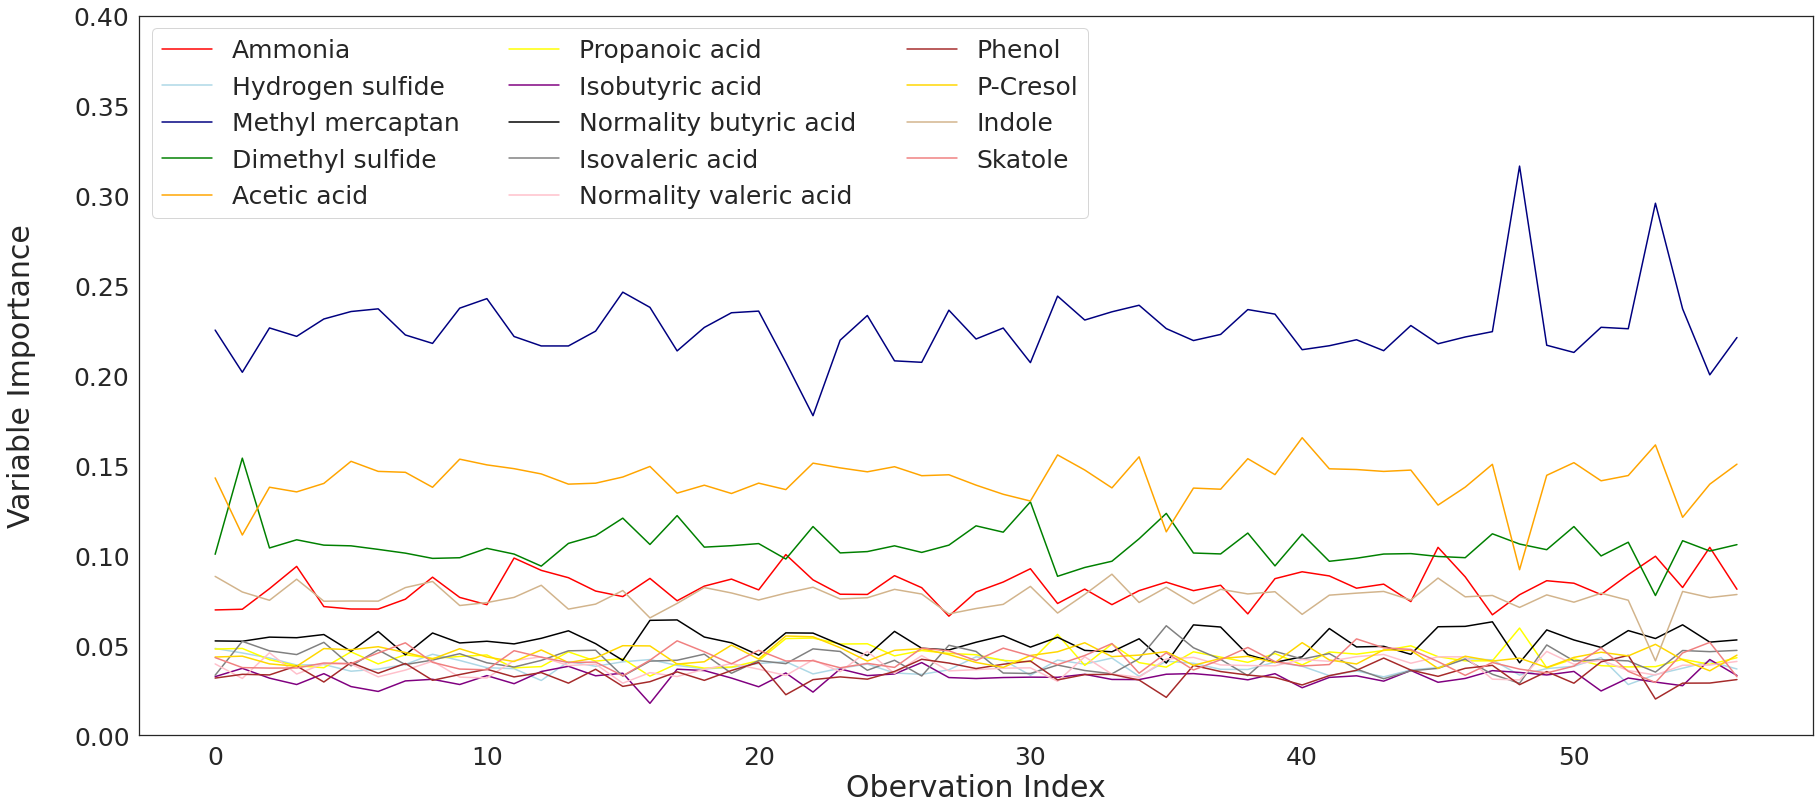

In [277]:
color = ["red", "lightblue", 'navy', "green", "orange", "yellow", "purple", "black", "gray", "pink", "brown", "gold", "tan", "lightcoral"]

plt.figure(figsize = (30, 45))
sns.set_style("white")

plt.subplot(3, 1, 1)
for i in range(odor2.shape[1]-1) :
  plt.plot(multivar_importance.iloc[i,:], label = multivar_importance.index[i], color = color[i])
#   plt.title("Variable Importance\nby Multivariate Imputation None Extra Tree \n", fontsize = 20)
  plt.ylabel("Variable Importance\n", fontsize = 30) ; plt.xlabel("Obervation Index", fontsize = 30)
  plt.xticks(fontsize = 25) ; plt.yticks(fontsize = 25)
  plt.ylim(0,0.4)
  plt.legend(loc = "upper left", labels = var_name[1:], ncol = 3, fontsize = 25)
    
# plt.subplot(3, 1, 2)
# for i in range(odor2.shape[1]-1) :
#   plt.plot(knn_importance1.iloc[i,:], label = knn_importance1.index[i])
#   plt.title("Variable Importance\nby KNN Imputation PCA XGboost", fontsize = 20)
#   plt.ylabel("Importance", fontsize = 15) ; plt.xlabel("Index", fontsize = 15)
#   plt.legend(loc = "upper left", labels = var_name[1:], ncol = 3)

    
# plt.subplot(3, 1, 3)
# for i in range(odor2.shape[1]-1) :
#   plt.plot(knn_importance2.iloc[i,:], label = knn_importance2.index[i])
#   plt.title("Variable Importance\nby KNN Imputation PCA Random Forest", fontsize = 20)
#   plt.ylabel("Importance", fontsize = 15) ; plt.xlabel("Index", fontsize = 15)
#   plt.legend(loc = "upper left", labels = var_name[1:], ncol = 3)

    
plt.show()

In [23]:
multivar_importance.index = var_name[1:]
knn_importance1.index = var_name[1:]
knn_importance2.index = var_name[1:]

mul_import_sort = pd.DataFrame(multivar_importance.mean(axis = 1).sort_values(ascending = False), columns = ["Multivariate importance"])
knn_import_sort1 = pd.DataFrame(knn_importance1.mean(axis = 1).sort_values(ascending = False), columns = ["KNN importance1"])
knn_import_sort2 = pd.DataFrame(knn_importance2.mean(axis = 1).sort_values(ascending = False), columns = ["KNN importance2"])


multi_table([mul_import_sort, knn_import_sort1, knn_import_sort2])

,Multivariate importance
Methyl mercaptan,0.226623
Acetic acid,0.142026
Dimethyl sulfide,0.105575
Ammonia,0.082458
Indole,0.076712
Normality butyric acid,0.052459
P-Cresol,0.044457
Propanoic acid,0.043491
Skatole,0.041858
Isovaleric acid,0.041626


In [25]:
multivar_importance

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
Ammonia,0.069702,0.070080,0.081534,0.093903,0.071559,0.070218,0.070172,0.075678,0.087907,0.076663,...,0.066993,0.078148,0.085944,0.084552,0.078246,0.089323,0.099551,0.082164,0.104498,0.081182
Hydrogen sulfide,0.048293,0.045778,0.042962,0.039052,0.039363,0.035630,0.036800,0.039424,0.045065,0.041613,...,0.041928,0.033472,0.037098,0.038376,0.043201,0.028220,0.033755,0.037287,0.040990,0.036870
Methyl mercaptan,0.225282,0.201830,0.226486,0.221792,0.231450,0.235602,0.237098,0.222572,0.217882,0.237476,...,0.224421,0.316463,0.216857,0.212851,0.226833,0.226027,0.295812,0.237091,0.200398,0.221148
Dimethyl sulfide,0.100625,0.154087,0.104153,0.108698,0.105725,0.105332,0.103361,0.101271,0.098359,0.098717,...,0.112031,0.106338,0.103192,0.116049,0.099715,0.107342,0.077716,0.108183,0.102441,0.106002
Acetic acid,0.143115,0.111365,0.137920,0.135325,0.140035,0.152323,0.146729,0.146215,0.137892,0.153524,...,0.150661,0.092057,0.144546,0.151569,0.141496,0.144421,0.161457,0.121192,0.139609,0.150742
Propanoic acid,0.047947,0.048293,0.042034,0.038665,0.037569,0.046394,0.039681,0.044770,0.042754,0.043842,...,0.041396,0.059620,0.037531,0.042521,0.038706,0.038025,0.038171,0.042275,0.039436,0.043143
Isobutyric acid,0.032609,0.037225,0.031779,0.028237,0.034266,0.027090,0.024383,0.030236,0.031134,0.028235,...,0.035947,0.034947,0.033549,0.035505,0.024640,0.031842,0.029590,0.027572,0.042124,0.033240
Normality butyric acid,0.052468,0.052291,0.054585,0.054256,0.056019,0.046657,0.057710,0.044753,0.056882,0.051338,...,0.063095,0.040317,0.058581,0.053006,0.048844,0.058220,0.053813,0.061419,0.051804,0.053024
Isovaleric acid,0.033395,0.052231,0.046945,0.044883,0.051688,0.038591,0.047456,0.039322,0.041845,0.045357,...,0.033931,0.028913,0.050223,0.041348,0.042020,0.041372,0.035138,0.047139,0.046501,0.047211
Normality valeric acid,0.039686,0.031598,0.045878,0.034066,0.039759,0.039598,0.032503,0.036254,0.041182,0.032340,...,0.031213,0.030775,0.046628,0.039493,0.041748,0.036018,0.033494,0.038951,0.039049,0.041066


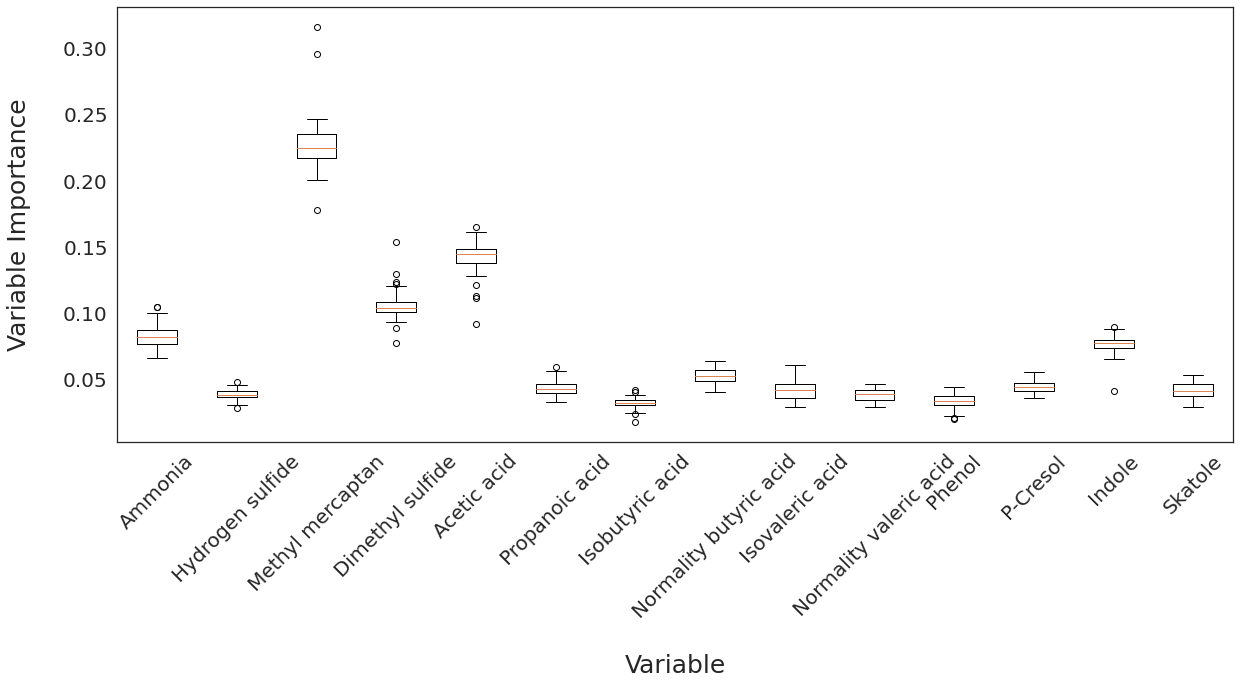

In [274]:
sns.set_style("white")
plt.figure(figsize = (20,8))
plt.boxplot(multivar_importance.T)
plt.xticks(list(range(1,15)), var_name[1:], rotation = 45, fontsize = 15)
plt.ylabel("Variable Importance\n", fontsize = 25) ; plt.xlabel("\nVariable", fontsize = 25)
plt.xticks(fontsize = 20) ; plt.yticks(fontsize = 20)
plt.show()

In [ ]:
sns.set_style("white")
plt.figure(figsize = (20,8))
plt.boxplot(multivar_importance.T)
plt.xticks(list(range(1,15)), var_name[1:], rotation = 45, fontsize = 15)
plt.ylabel("Variable Importance\n", fontsize = 25) ; plt.xlabel("\nVariable", fontsize = 25)
plt.xticks(fontsize = 20) ; plt.yticks(fontsize = 20)
plt.show()

# **결측있는 변수 제거 결과**

In [47]:
odor_md = odor.copy()
display(odor_md.head(3))

odor_md = odor_md.drop(["mm", "dms", "dmds"], axis = 1)
display(odor_md.head(3))

,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,NaN,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,NaN,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


,ou,nh3,h2s,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


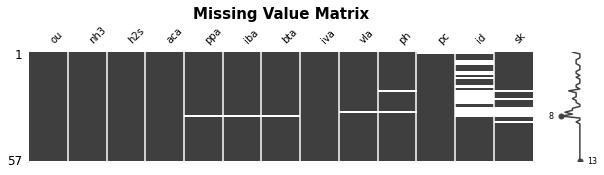

In [48]:
# odor_md.columns = ["OU", "Ammonia", "Hydrogen sulfide", "Acetic acid", "Propanoic acid", 
#                    "Isobutyric acid", "Normality butyric acid", "Isovaleric acid", "Normality valeric acid", "Phenol", "P-Cresol", "Indole", "Skatole"]

msno.matrix(odor_md, figsize=(10,2), fontsize = 10)
plt.title("Missing Value Matrix", fontsize = 15, fontweight = "bold")
plt.show()

In [49]:
Missings = ["Simple(Mean) Imp", "Simple(Median) Imp",
            "Multivariate(BayesianRidge) Imp", "Multivariate(ExtraTree) Imp", 
            "Multiple(BayesianRidge) Imp", "Multiple(GaussianProcessRegressor) Imp",
            "KNN Imp"]
Variables = ["None", "PCA", "PLS"]
Models = ["Regression", "SVR", "Random Forest", "Extra Tree", "XGboost", "DNN"]

In [50]:
# from tqdm.notebook import tqdm

# preds_df1 = pd.DataFrame(index = range(0, 57))

# for i in tqdm(range(len(Missings))) :
#   for j in range(len(Variables)) :
#     for k in range(len(Models)) :
#       result = Odor(data = odor_md, missing = Missings[i], Variable = Variables[j], Model = Models[k])

#       pred = result["prediction"]
#       pred_df1 = pd.DataFrame(pred, columns = [Missings[i] + "_" + Variables[j] + "_" + Models[k]])
#       preds_df1 = pd.concat([preds_df1, pred_df1], axis = 1)

In [51]:
# display(preds_df1.head(3))
# print(preds_df1.shape)
# preds_df1.to_csv(output_path + "Prediction results (결측 변수 제거).csv", index = False)

In [54]:
preds_df1 = pd.read_csv(output_path + "Prediction results (결측 변수 제거).csv")
actual2 = odor_md.loc[:,"ou"]
r2_ols_list2 = []
mape_list2 = []

for i in range(preds_df1.shape[1]) :
    const_pred_list = sm.add_constant(preds_df1.iloc[:, i], has_constant = "add")
    ols = sm.OLS(actual2, const_pred_list).fit()
    r2_ols_list2.append(np.round(ols.rsquared, 3))
    mape_list2.append(mape(actual2, preds_df1.iloc[:, i]))

In [61]:
r2_ols_df2 = pd.DataFrame([r2_ols_list2, mape_list2], index = ["R2 (ols)", "R2 (mape)"], columns = preds_df1.columns).T
sort_r2_ols_df2 = r2_ols_df2.sort_values(by = ["R2 (ols)"], ascending = False)

rank = 5
best_models_df2 = pd.DataFrame([sort_r2_ols_df2.index[:rank], sort_r2_ols_df2.iloc[:rank, 0], sort_r2_ols_df2.iloc[:rank, 1]], index = ["R2 (ols)", "R2 (ols) value", "R2 (mape)"]).T

best_models_df2 

# r2_best_models2 = ['Multivariate(BayesianRidge) Imp_None_Extra Tree', 'KNN Imp_PCA_XGboost', 'KNN Imp_PCA_Random Forest']
# color_at_df(best_models_df2, r2_best_models2, "pink")

,R2 (ols),R2 (ols) value,R2 (mae)
0,Simple(Median) Imp_None_Extra Tree,0.315,939.8
1,Simple(Mean) Imp_None_Extra Tree,0.311,964.681
2,Multivariate(BayesianRidge) Imp_None_Extra Tree,0.311,982.796
3,KNN Imp_None_Extra Tree,0.305,961.717
4,Multivariate(BayesianRidge) Imp_PCA_Extra Tree,0.268,959.853


# **Etc**

In [ ]:
plt.figure(figsize = (20, 5))

plt.subplot(2, 1, 1)
plt.plot(r2_ols_list, color = "black", marker = "o")
plt.title("R2 (Ols)", fontsize = 20)

plt.subplot(2, 1, 2)
plt.plot(mape_list, color = "black", marker = "o")
plt.title("mape", fontsize = 20)

plt.tight_layout()
plt.show()

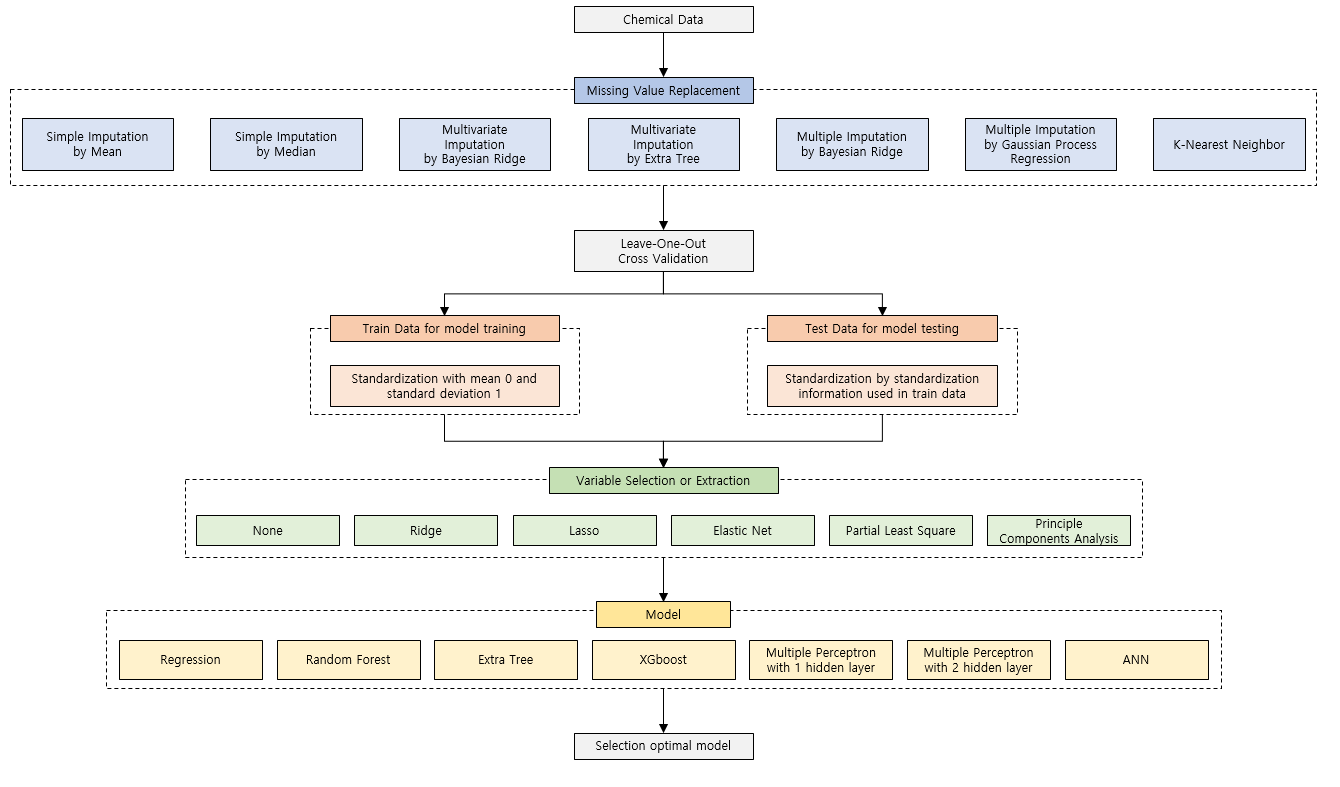

In [258]:
import platform
print(platform.python_version())

3.7.10
